In [1]:
import pandas as pd
import os

In [2]:
f_list = os.listdir()
f_list = [f for f in f_list if f.endswith('.csv')]
len(f_list)

20

In [3]:
res_dict = {}
for i in range(20):
    i += 1
    res_dict[i] = pd.read_csv('res5_{}.csv'.format(i), index_col=0)

    

In [4]:
res_dict[1].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FCAMR,38.600075,1.862972,0.305314,6.101829,1.048614e-09,0.000015
MTND1P23,1356.668730,4.153882,0.826747,5.024369,5.050915e-07,0.003703
DTX1,63.084832,1.542195,0.329511,4.680254,2.865203e-06,0.014005
RGS13,54.019264,1.424862,0.341928,4.167146,3.084372e-05,0.113073
CR2,233.050953,2.128658,0.564743,3.769252,1.637377e-04,0.460307


In [5]:
res_dict[1].shape

(14664, 6)

<Axes: >

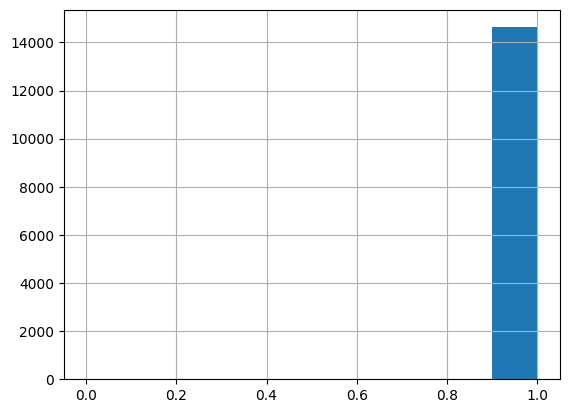

In [6]:
res_dict[1]['padj'].hist()

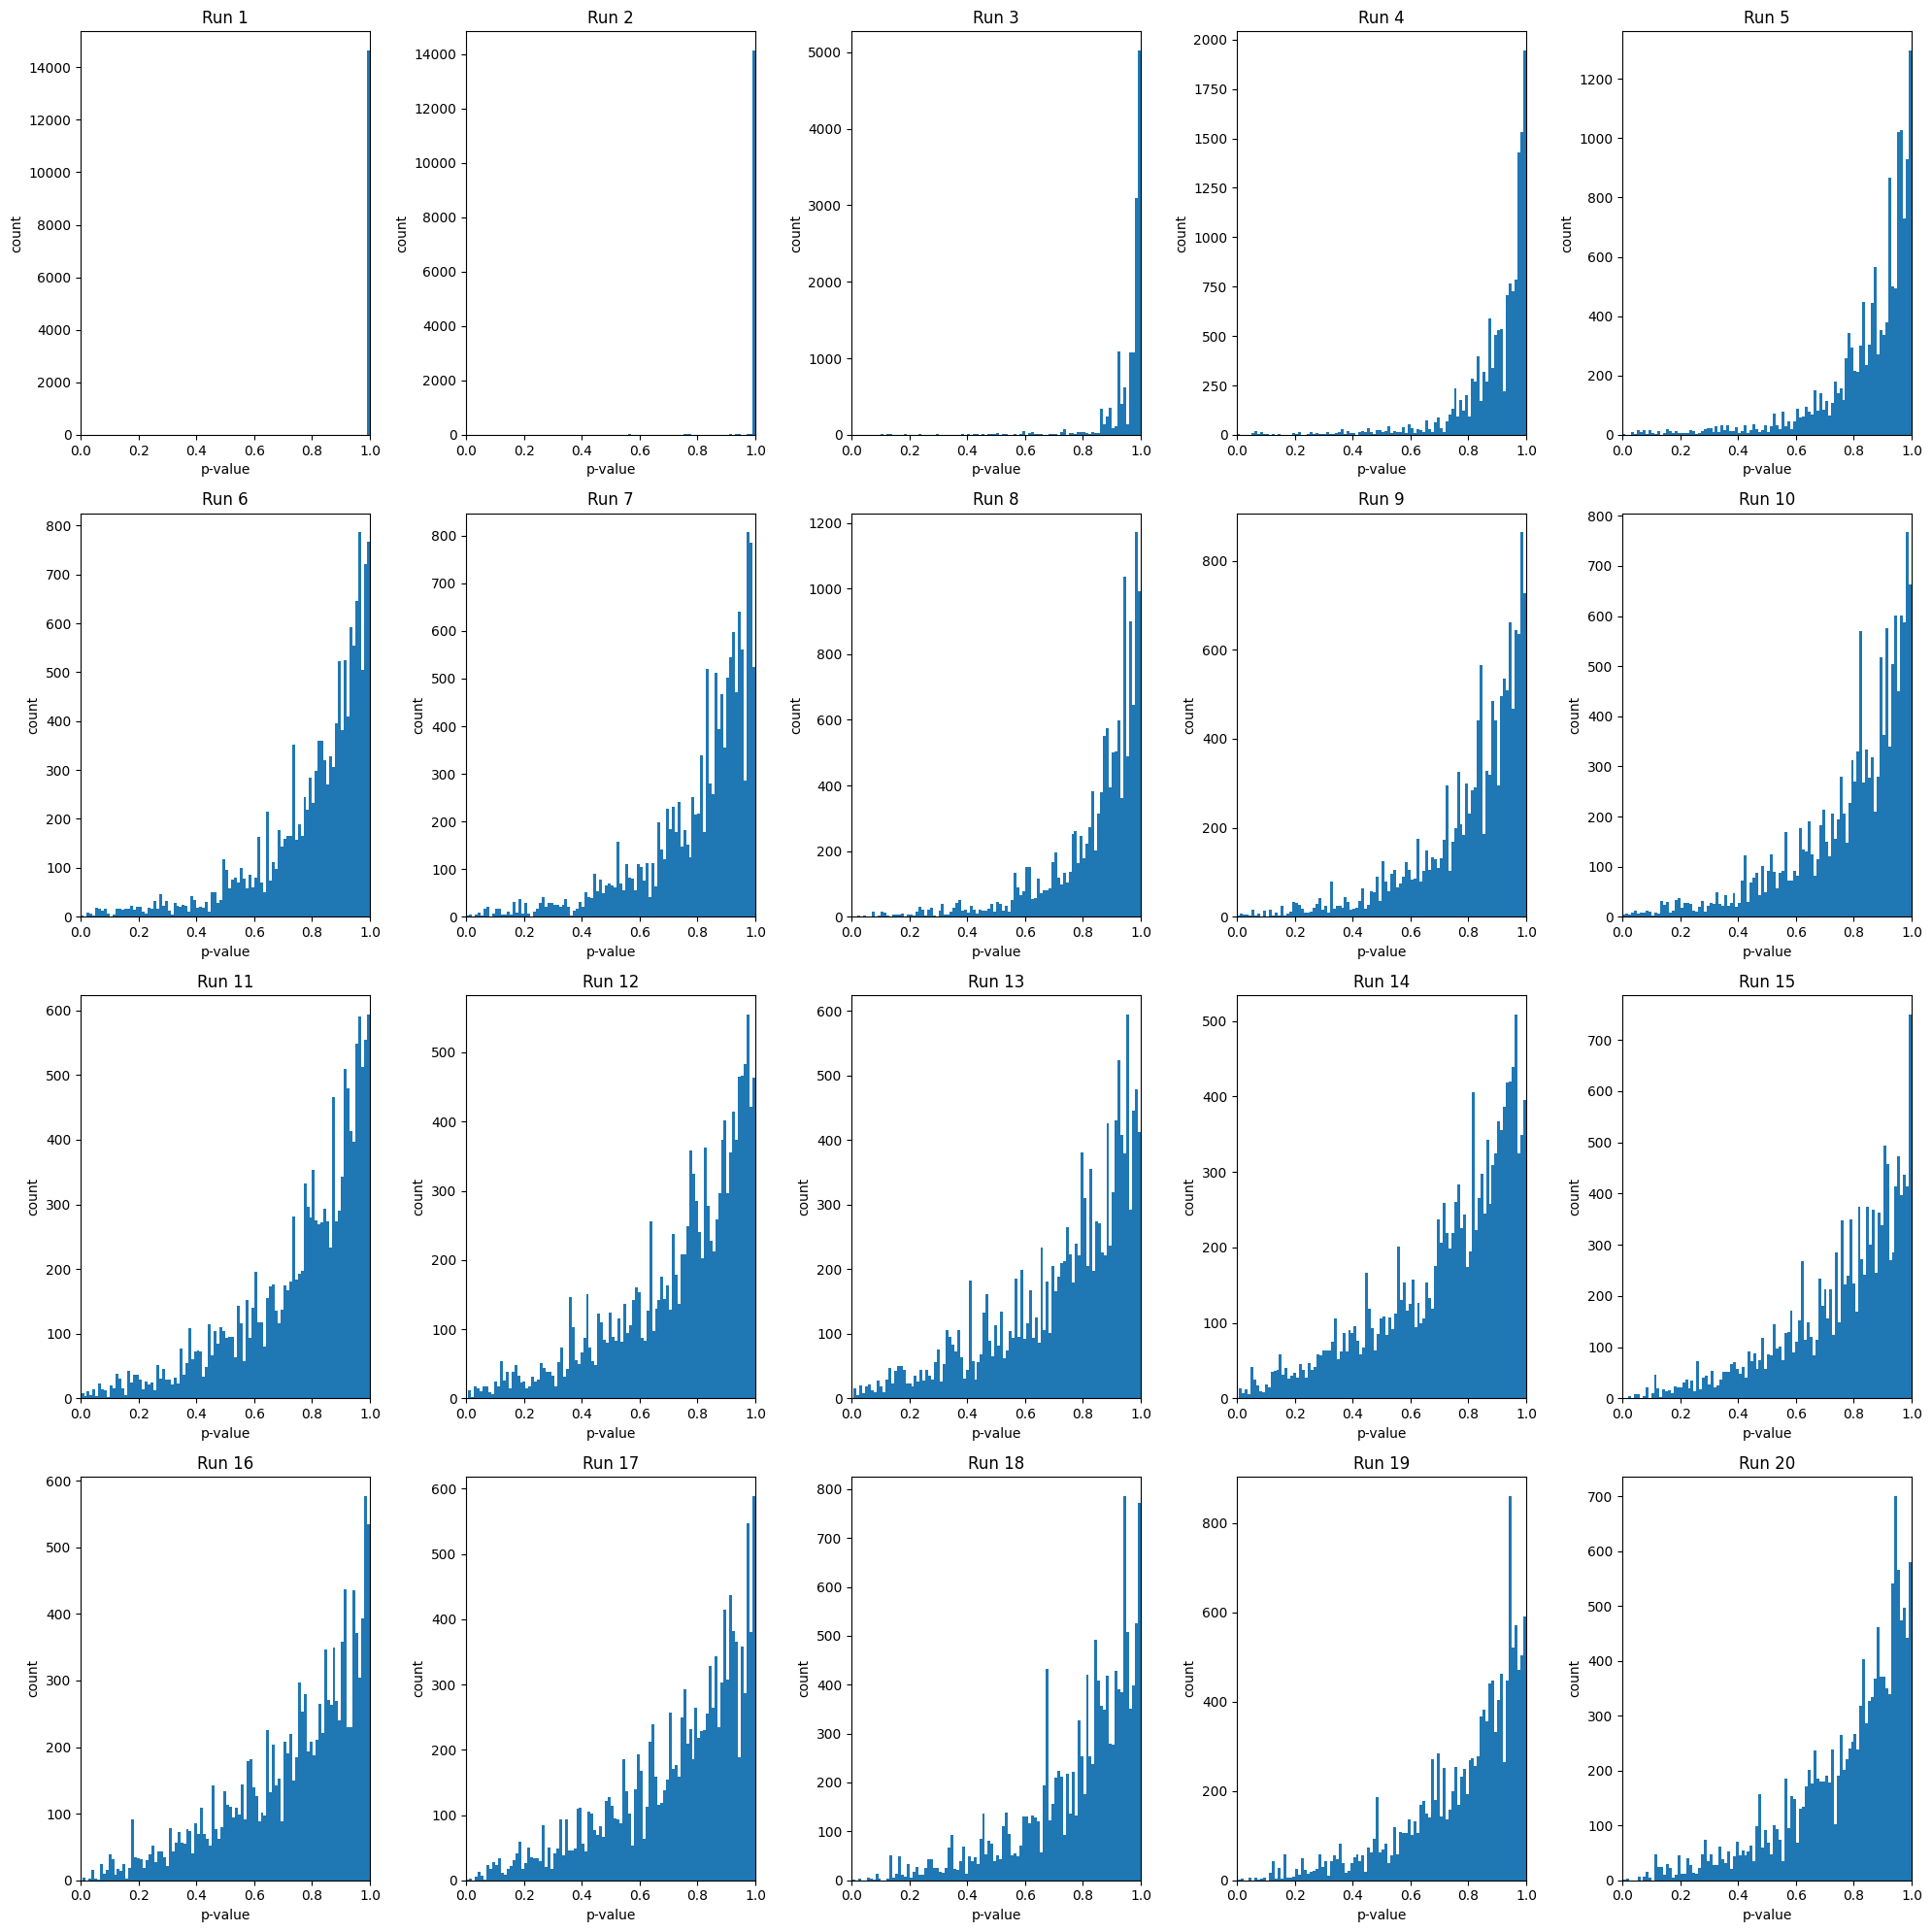

In [7]:
#plot all pval histograms on one plot in a 5x4 grid
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = axes.flatten()
for i in range(1, 21):
    axes[i-1].hist(res_dict[i]['padj'], bins=100)
    axes[i-1].set_title('Run {}'.format(i))
    axes[i-1].set_xlabel('p-value')
    axes[i-1].set_ylabel('count')
    axes[i-1].set_xlim(0, 1)
    
plt.tight_layout()
plt.show()
# plt.savefig('pval_hist_5.png', bbox_inches='tight', dpi=300)

In [8]:
#fit a best fit line (y = mx + b) to each histogram
import numpy as np
from scipy.optimize import curve_fit
best_fit = pd.DataFrame(columns=['run', 'slope', 'intercept'])
for i in range(1, 21):
    #drop NA values
    res_dict[i] = res_dict[i].dropna(subset=['padj'])
    hist, bins = np.histogram(res_dict[i]['padj'], bins=100)
    bins = bins[:-1]
    def func(x, m, b):
        return m*x + b
    slope_intercept, pcov = curve_fit(func, bins, hist)
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    best_fit.loc[i, 'run'] = i
    best_fit.loc[i, 'slope'] = slope
    best_fit.loc[i, 'intercept'] = intercept
#get the slope of each line
slope_df = pd.DataFrame()
for i in range(1, 21):
    slope_df.loc[i, 'slope'] = best_fit.loc[i, 'slope']
slope_df['run'] = slope_df.index

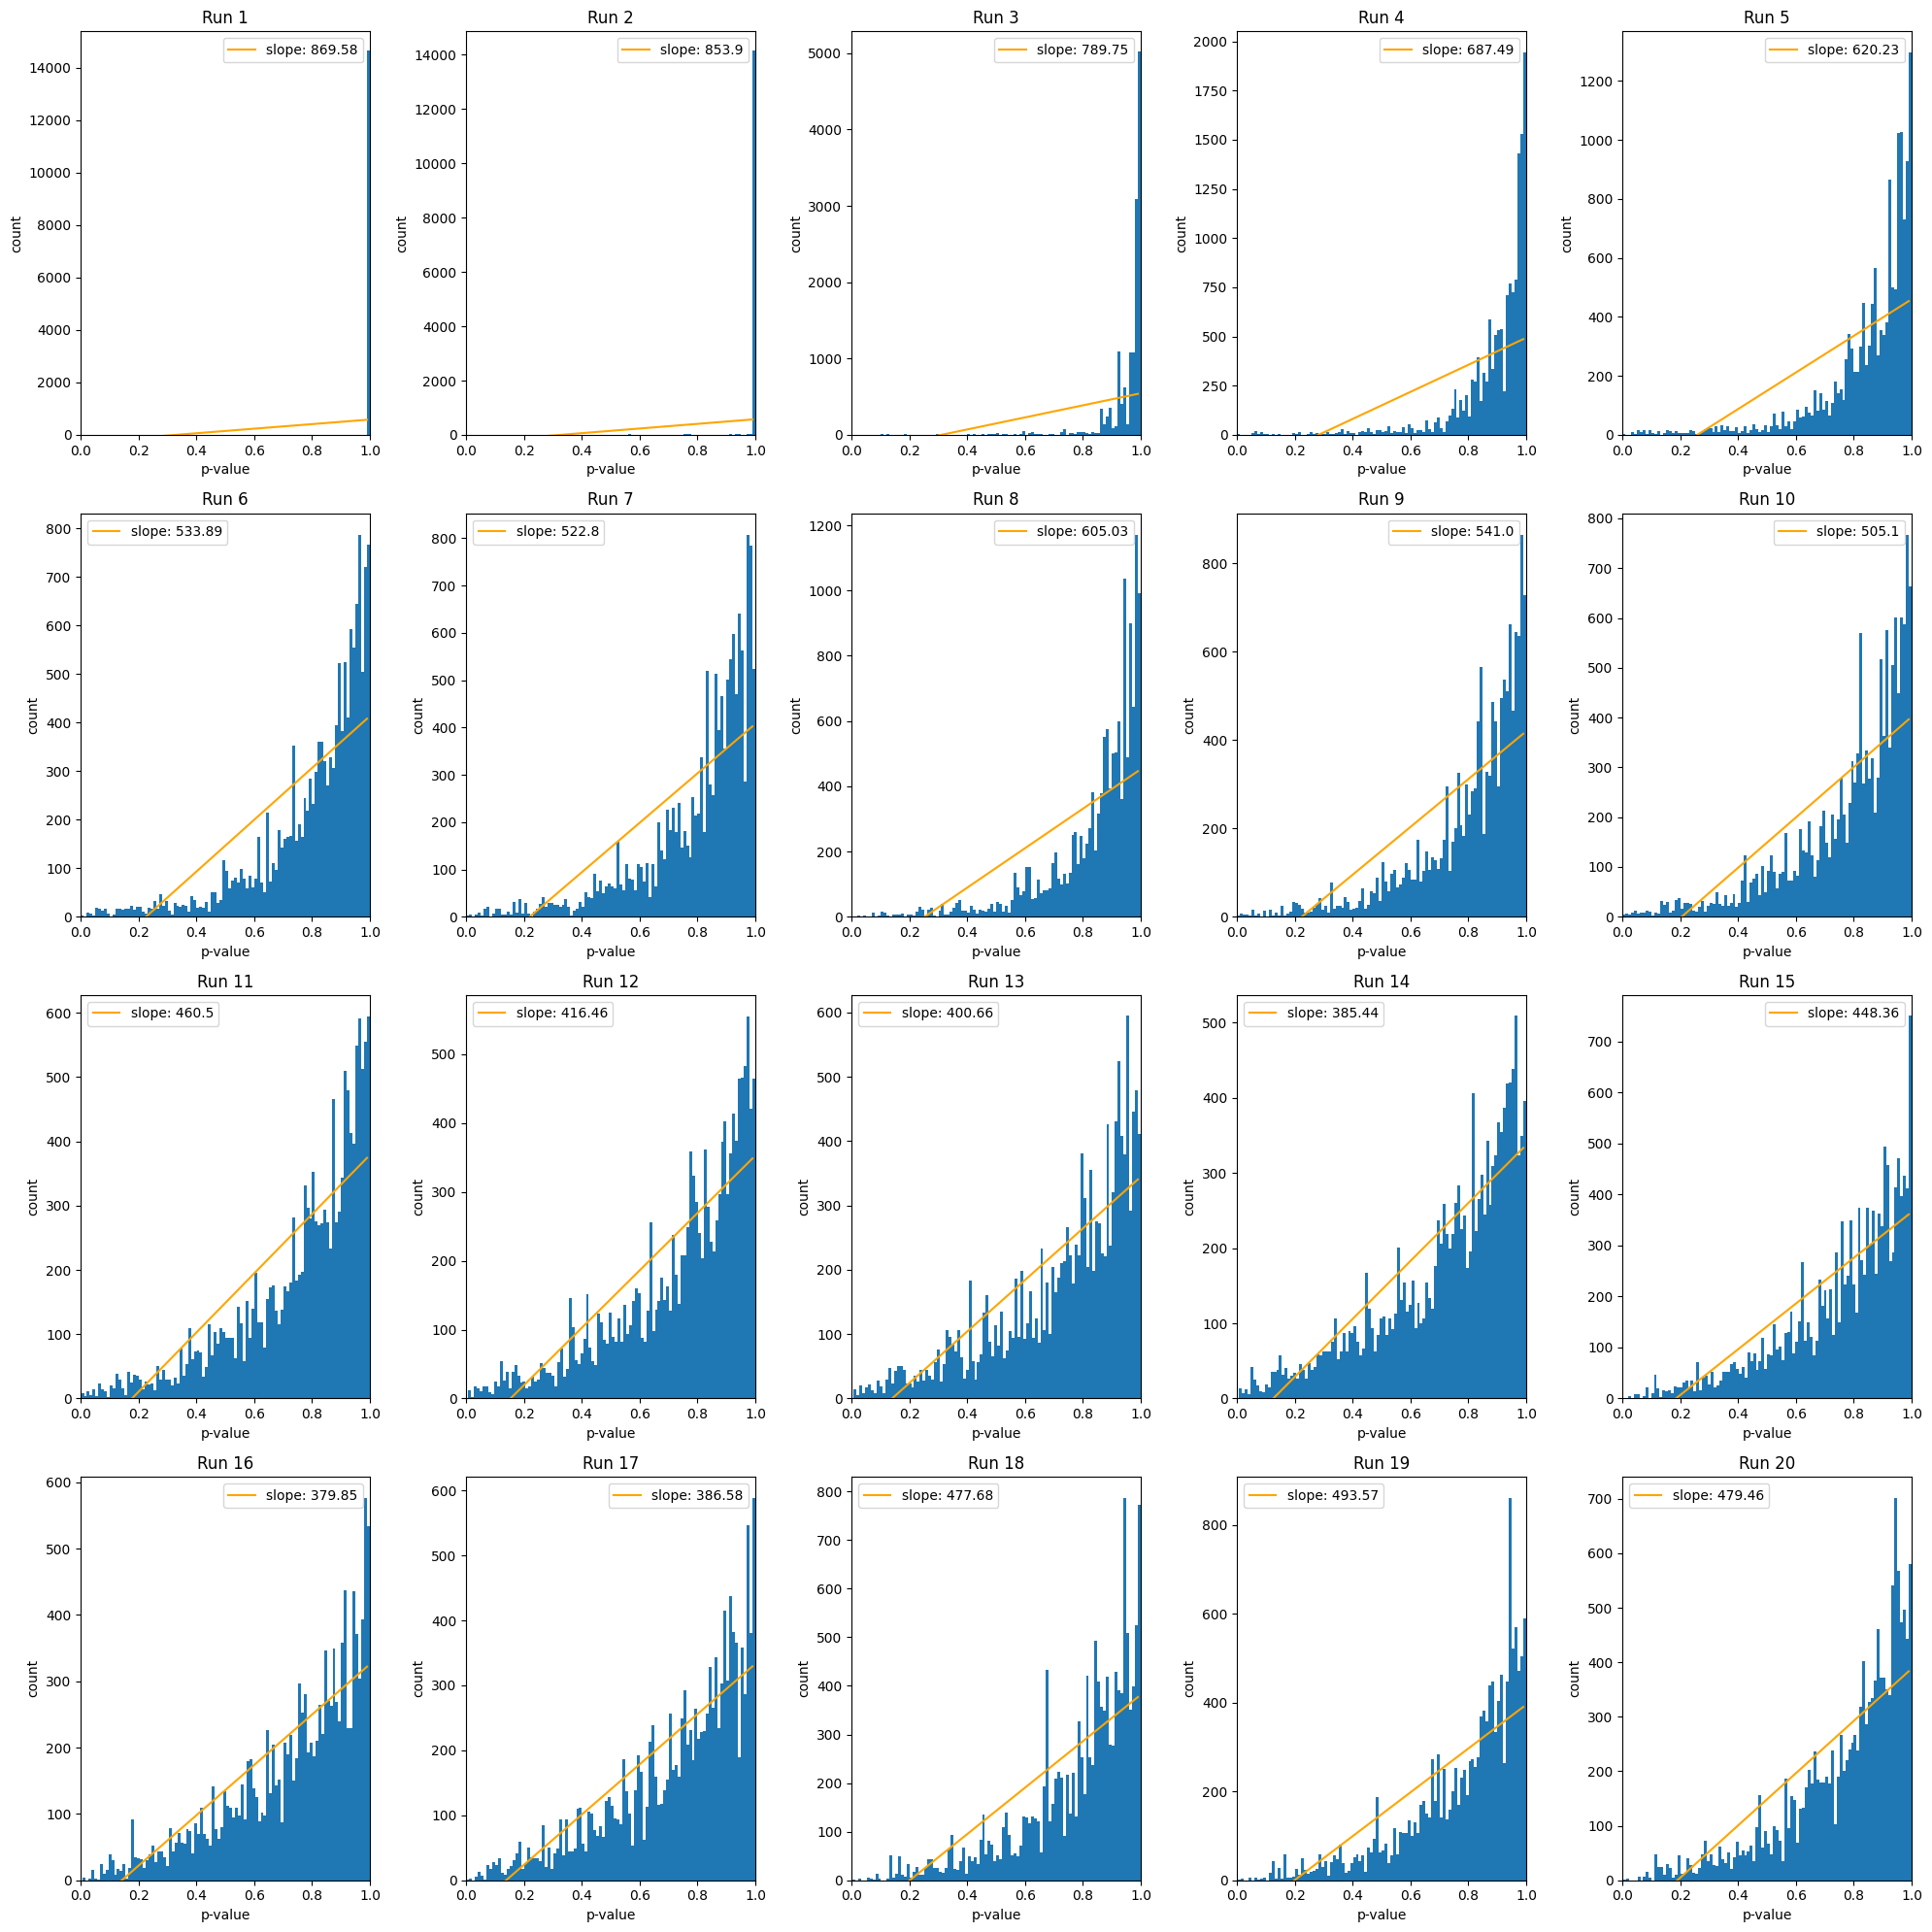

In [9]:
#plot the slopes on the histograms
#first make a function to plot the best fit line
def plot_best_fit(run, ax):
    hist, bins = np.histogram(res_dict[run]['padj'], bins=100)
    bins = bins[:-1]
    # ax.plot(bins, hist, label='Run {}'.format(run))
    #plot the histogram as bars, not lines

    #make the line orange
    ax.plot(bins, slope_df.loc[run, 'slope']*bins + best_fit.loc[run, 'intercept'], label='slope: {}'.format(round(slope_df.loc[run, 'slope'], 2)), color='orange')
    ax.legend()
    ax.set_xlabel('p-value')
    ax.set_ylabel('count')
    ax.set_title('Run {}'.format(run))
    ax.set_xlim(0, 1)
    #set the y axis to only positive values
    ax.set_ylim(0, ax.get_ylim()[1])
    return ax
#plot the best fit lines
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = axes.flatten()
for i in range(1, 21):
    axes[i-1].hist(res_dict[i]['padj'], bins=100)
    plot_best_fit(i, axes[i-1])
plt.tight_layout()
plt.savefig('pval_hist_5.png', bbox_inches='tight', dpi=300)


In [10]:
sig_genes = {}
for i in range(1, 21):
    sig_genes[i] = res_dict[i][res_dict[i]['padj'] < 0.05].index.to_list()

In [11]:
#for each gene list get the number of genes that are in the other gene lists
overlap_df = pd.DataFrame(index=sig_genes.keys(), columns=sig_genes.keys())
for i in range(1,21):
    for j in range(1,21):
        overlap_df.loc[i, j] = len(set(sig_genes[i]).intersection(set(sig_genes[j])))


In [12]:
overlap_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,3,3,2,2,2,2,3,3,3,3,2,2,2,1,0,0,0,0,0,0
2,3,5,4,4,4,4,5,5,5,5,4,4,4,2,0,1,1,0,0,0
3,2,4,4,4,4,4,4,4,4,4,4,4,4,2,0,1,1,0,0,0
4,2,4,4,5,5,5,5,5,5,5,5,5,5,3,1,2,2,0,0,0
5,2,4,4,5,16,15,14,9,11,14,14,14,14,12,5,8,8,3,3,3
6,2,4,4,5,15,20,15,9,11,17,19,19,19,17,5,9,9,3,3,3
7,3,5,4,5,14,15,19,10,13,17,17,17,17,14,6,10,10,4,4,4
8,3,5,4,5,9,9,10,11,11,11,10,10,10,8,4,5,6,2,2,2
9,3,5,4,5,11,11,13,11,19,19,18,18,18,16,8,11,10,4,5,4
10,3,5,4,5,14,17,17,11,19,36,35,34,34,31,10,19,17,4,7,4


In [13]:
overlap_df = overlap_df.astype(int)

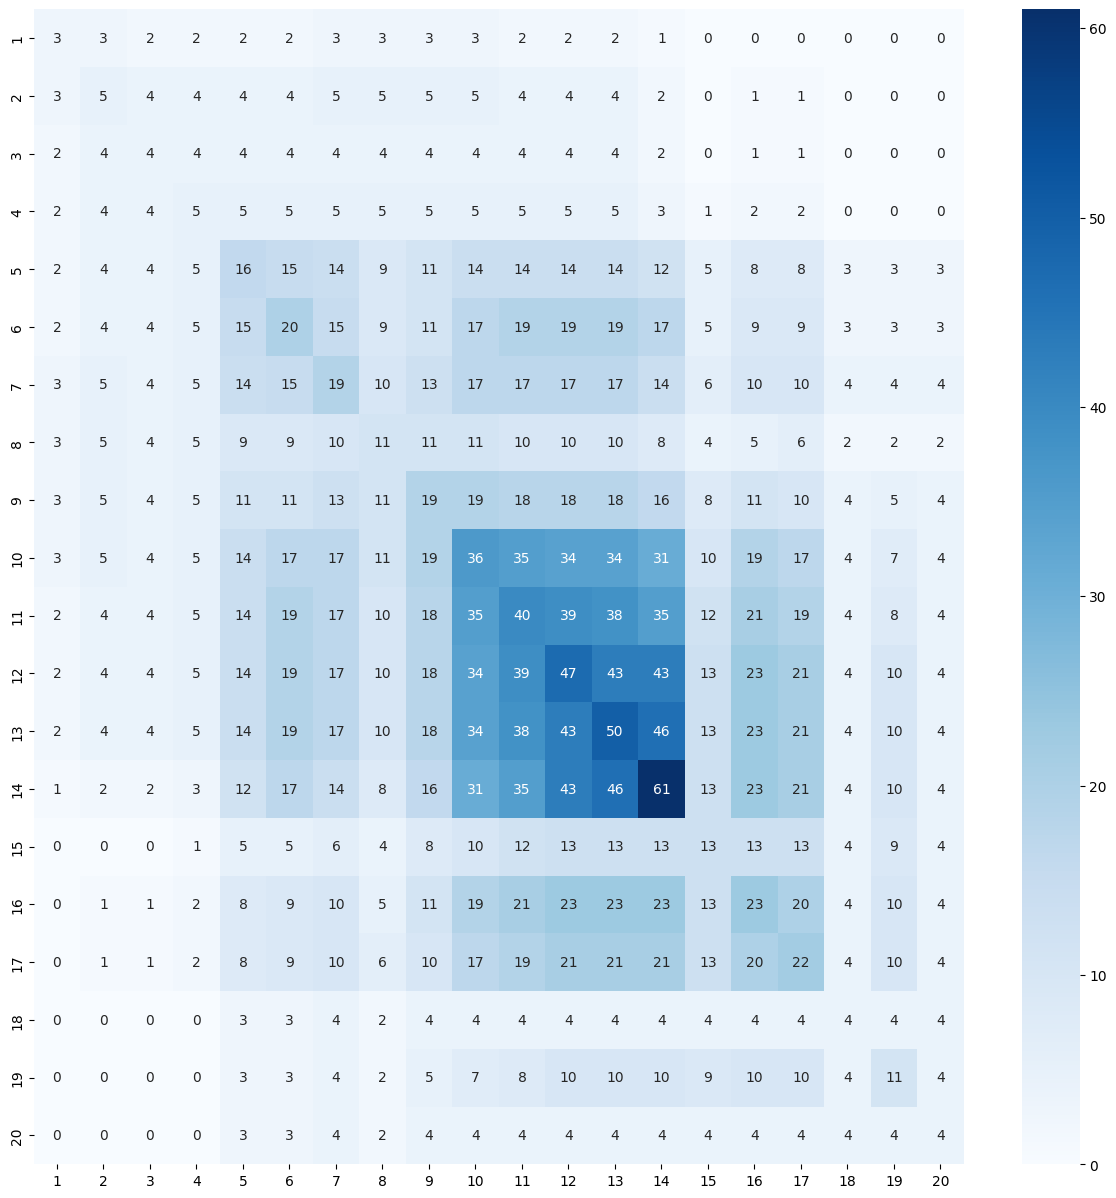

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(overlap_df, annot=True, cmap='Blues', fmt='d')
#make the plot bigger
plt.rcParams['figure.figsize'] = [15, 15]
plt.savefig('overlap_heatmap.png', bbox_inches='tight', dpi=300)

In [15]:
#check if the first 20 genes in res_dict[9] are the same as the first 20 genes in the other runs
top_20 = res_dict[13].index[:20].to_list()
top_20_frac = {}
for i in range(1, 21):
    top_20_frac[i] = len(set(top_20).intersection(set(res_dict[i].index[:20].to_list())))/20
top_20_frac

{1: 0.1,
 2: 0.15,
 3: 0.15,
 4: 0.35,
 5: 0.35,
 6: 0.35,
 7: 0.4,
 8: 0.35,
 9: 0.45,
 10: 0.55,
 11: 0.75,
 12: 0.9,
 13: 1.0,
 14: 0.8,
 15: 0.8,
 16: 0.8,
 17: 0.75,
 18: 0.7,
 19: 0.75,
 20: 0.7}

In [16]:
#create a dataframe of the top 20 genes for each run
top_20_df = pd.DataFrame(index=range(1, 12), columns=range(1, 21))
#exclude genes starting with 'ENSG'
no_ensg = {}
for i in range(1, 21):
    no_ensg[i] = [gene for gene in res_dict[i].index if not gene.startswith('ENSG')]
    top_20_df.loc[i] = no_ensg[i][:20]
top_20_df = top_20_df.T
top_20_df.head(15)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,EEF1A1P13,EEF1A1P13,EEF1A1P13,EEF1A1P13,FCAMR,FCAMR,FCAMR,FCAMR,STK17B,STK17B,STK17B,STK17B,WIPF1,WIPF1,WIPF1,WIPF1,STK17B,STK17B,STK17B,STK17B
2,RGS13,FCAMR,FCAMR,FCAMR,RGS13,UGCG,UGCG,UGCG,FCAMR,ZNF331,FADS3,WIPF1,STK17B,STK17B,STK17B,STK17B,WIPF1,WIPF1,WIPF1,WIPF1
3,FCAMR,RGS13,RGS13,RGS13,EEF1A1P13,RGS13,RGS13,MRPL15,ZNF331,FCAMR,ZNF331,FADS3,PHACTR1,PHACTR1,CHMP2A,PHACTR1,UGCG,UGCG,UGCG,UGCG
4,MIR222HG,MIR222HG,MIR222HG,DTX1,STK17B,MRPL15,STK17B,RGS13,UGCG,UGCG,WIPF1,ZNF331,RASSF2,RASSF2,PHACTR1,CHMP2A,PHACTR1,FADS3,FADS3,FADS3
5,ZNF331,ZNF331,ZNF331,ZNF331,UGCG,EEF1A1P13,MRPL15,MIR222HG,RASSF2,S1PR2,UGCG,RASSF2,UGCG,UGCG,RASSF2,UGCG,CHMP2A,PHACTR1,PTPRC,MRPL12
6,MTND1P23,ARL14,DTX1,MIR222HG,MRPL15,STK17B,MIR222HG,STK17B,WIPF1,FADS3,S1PR2,UGCG,CHMP2A,CHMP2A,UGCG,SNN,FADS3,MRPL12,CHMP2A,PHACTR1
7,STAP1,DTX1,ARL14,STK17B,RASSF2,ZNF331,EEF1A1P13,EEF1A1P13,FADS3,RASSF2,RASSF2,CHMP2A,RELT,PIK3CD,S1PR2,S1PR2,MRPL12,CHMP2A,SNN,PTPRC
8,ARL14,RFTN1,RFTN1,RASSF2,MIR222HG,RASSF2,RASSF2,ARL14,DENND4A,WIPF1,CHMP2A,S1PR2,SNN,MRPL12,NCOA3,NCOA3,NCOA3,PTPRC,PHACTR1,SNN
9,DTX1,STAP1,SWAP70,ARL14,DTX1,DTX1,ZNF165,ZNF165,MIR222HG,DENND4A,RELT,PIK3CD,S1PR2,FADS3,PIK3CD,PIK3CD,SNN,NCOA3,MRPL12,P2RY10
10,ERRFI1,VNN2,VNN2,C16orf54,MCL1,ZNF165,ZNF331,ZNF331,SNN,MIR222HG,MRPL12,MRPL12,PIK3CD,S1PR2,MRPL12,MRPL12,S1PR2,SNN,P2RY10,CHMP2A


In [17]:
    

for i in range(1, 21):
    top_20_df.loc[i] = res_dict[i].index[:20].to_list()
top_20_df = top_20_df.T
top_20_df.head(15)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,EEF1A1P13,EEF1A1P13,EEF1A1P13,EEF1A1P13,FCAMR,FCAMR,ENSG00000261553,ENSG00000261553,ENSG00000261553,ENSG00000261553,ENSG00000261553,ENSG00000261553,ENSG00000261553,ENSG00000261553,WIPF1,WIPF1,STK17B,STK17B,STK17B,STK17B
2,RGS13,FCAMR,FCAMR,FCAMR,RGS13,UGCG,FCAMR,FCAMR,STK17B,STK17B,STK17B,STK17B,WIPF1,WIPF1,STK17B,STK17B,WIPF1,WIPF1,WIPF1,WIPF1
3,FCAMR,RGS13,RGS13,RGS13,EEF1A1P13,RGS13,UGCG,UGCG,FCAMR,ZNF331,FADS3,WIPF1,STK17B,STK17B,ENSG00000261553,ENSG00000261553,UGCG,ENSG00000261553,ENSG00000261553,UGCG
4,MIR222HG,ENSG00000261553,ENSG00000261553,ENSG00000261553,STK17B,MRPL15,RGS13,MRPL15,ZNF331,FCAMR,ZNF331,FADS3,PHACTR1,PHACTR1,CHMP2A,PHACTR1,ENSG00000261553,UGCG,UGCG,ENSG00000261553
5,ENSG00000261553,MIR222HG,MIR222HG,DTX1,UGCG,EEF1A1P13,STK17B,RGS13,UGCG,UGCG,WIPF1,ZNF331,RASSF2,RASSF2,PHACTR1,CHMP2A,PHACTR1,FADS3,FADS3,FADS3
6,ZNF331,ZNF331,ZNF331,ZNF331,ENSG00000261553,STK17B,MRPL15,MIR222HG,RASSF2,S1PR2,UGCG,RASSF2,UGCG,UGCG,RASSF2,UGCG,CHMP2A,PHACTR1,PTPRC,MRPL12
7,MTND1P23,ARL14,DTX1,MIR222HG,MRPL15,ENSG00000261553,MIR222HG,STK17B,WIPF1,FADS3,S1PR2,UGCG,CHMP2A,CHMP2A,UGCG,SNN,FADS3,MRPL12,CHMP2A,PHACTR1
8,STAP1,DTX1,ARL14,STK17B,RASSF2,ZNF331,EEF1A1P13,EEF1A1P13,FADS3,RASSF2,RASSF2,CHMP2A,RELT,PIK3CD,S1PR2,S1PR2,MRPL12,CHMP2A,SNN,PTPRC
9,ARL14,RFTN1,RFTN1,RASSF2,MIR222HG,RASSF2,RASSF2,ARL14,DENND4A,WIPF1,CHMP2A,S1PR2,SNN,MRPL12,NCOA3,NCOA3,NCOA3,ENSG00000280138,PHACTR1,SNN
10,ENSG00000272913,STAP1,SWAP70,ARL14,ENSG00000274322,ENSG00000274322,ZNF165,ZNF165,MIR222HG,DENND4A,RELT,ENSG00000277701,S1PR2,FADS3,PIK3CD,PIK3CD,SNN,PTPRC,ENSG00000280138,P2RY10


In [18]:
#keep only the odd numbered columns
top_20_df = top_20_df.iloc[:, ::2]


In [19]:
top_20_df.head(20)

,1,3,5,7,9,11,13,15,17,19
1,EEF1A1P13,EEF1A1P13,FCAMR,ENSG00000261553,ENSG00000261553,ENSG00000261553,ENSG00000261553,WIPF1,STK17B,STK17B
2,RGS13,FCAMR,RGS13,FCAMR,STK17B,STK17B,WIPF1,STK17B,WIPF1,WIPF1
3,FCAMR,RGS13,EEF1A1P13,UGCG,FCAMR,FADS3,STK17B,ENSG00000261553,UGCG,ENSG00000261553
4,MIR222HG,ENSG00000261553,STK17B,RGS13,ZNF331,ZNF331,PHACTR1,CHMP2A,ENSG00000261553,UGCG
5,ENSG00000261553,MIR222HG,UGCG,STK17B,UGCG,WIPF1,RASSF2,PHACTR1,PHACTR1,FADS3
6,ZNF331,ZNF331,ENSG00000261553,MRPL15,RASSF2,UGCG,UGCG,RASSF2,CHMP2A,PTPRC
7,MTND1P23,DTX1,MRPL15,MIR222HG,WIPF1,S1PR2,CHMP2A,UGCG,FADS3,CHMP2A
8,STAP1,ARL14,RASSF2,EEF1A1P13,FADS3,RASSF2,RELT,S1PR2,MRPL12,SNN
9,ARL14,RFTN1,MIR222HG,RASSF2,DENND4A,CHMP2A,SNN,NCOA3,NCOA3,PHACTR1
10,ENSG00000272913,SWAP70,ENSG00000274322,ZNF165,MIR222HG,RELT,S1PR2,PIK3CD,SNN,ENSG00000280138


In [20]:
#make a heatmap of the top 20 genes in each run
top_20_genes = {}
for i in range(1, 21):
    top_20_genes[i] = res_dict[i].index[:20].to_list()
top_20_genes_df = pd.DataFrame.from_dict(top_20_genes, orient='index')
for i in range(1, 21):
    top_20_genes_df.rename(columns={i: 'Run {}'.format(i)}, inplace=True)
top_20_genes_df.head(10)


,0,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,Run 10,Run 11,Run 12,Run 13,Run 14,Run 15,Run 16,Run 17,Run 18,Run 19
1,EEF1A1P13,RGS13,FCAMR,MIR222HG,ENSG00000261553,ZNF331,MTND1P23,STAP1,ARL14,ENSG00000272913,DTX1,ERRFI1,MRPL15,PDE4B,MCL1,KIAA0040,MYBL1,CR2,ZNF165,IRAG2
2,EEF1A1P13,FCAMR,RGS13,ENSG00000261553,MIR222HG,ZNF331,ARL14,DTX1,RFTN1,STAP1,VNN2,PDE4B,ENSG00000272913,KIAA0040,GCSAM,MYBL1,ZNF165,OTUD1,ENSG00000274322,S1PR2
3,EEF1A1P13,FCAMR,RGS13,ENSG00000261553,MIR222HG,ZNF331,DTX1,ARL14,RFTN1,SWAP70,VNN2,ENSG00000274322,REL,NFATC2,STAP1,RELT,CD72,PDE4B,MCL1,KIAA0040
4,EEF1A1P13,FCAMR,RGS13,ENSG00000261553,DTX1,ZNF331,MIR222HG,STK17B,RASSF2,ARL14,C16orf54,SEMA4A,RFTN1,RELT,PHACTR1,SWAP70,ERRFI1,MRPL15,PDE4B,ENSG00000274322
5,FCAMR,RGS13,EEF1A1P13,STK17B,UGCG,ENSG00000261553,MRPL15,RASSF2,MIR222HG,ENSG00000274322,DTX1,MCL1,ZNF331,C16orf54,ENSG00000272913,TGIF2,REL,SEMA4A,PHACTR1,RFTN1
6,FCAMR,UGCG,RGS13,MRPL15,EEF1A1P13,STK17B,ENSG00000261553,ZNF331,RASSF2,ENSG00000274322,DTX1,ENSG00000272913,ZNF165,MIR222HG,S1PR2,MCL1,FADS3,REL,C16orf54,TGIF2
7,ENSG00000261553,FCAMR,UGCG,RGS13,STK17B,MRPL15,MIR222HG,EEF1A1P13,RASSF2,ZNF165,ENSG00000274322,ZNF331,DTX1,S1PR2,ENSG00000272913,WDR24,RELT,KBTBD2,MCL1,FADS3
8,ENSG00000261553,FCAMR,UGCG,MRPL15,RGS13,MIR222HG,STK17B,EEF1A1P13,ARL14,ZNF165,ZNF331,ENSG00000272913,RASSF2,ENSG00000274322,MCL1,ENSG00000260711,DTX1,RELT,KBTBD2,S1PR2
9,ENSG00000261553,STK17B,FCAMR,ZNF331,UGCG,RASSF2,WIPF1,FADS3,DENND4A,MIR222HG,SNN,RGS13,REL,MRPL15,FOXO1,PHACTR1,EEF1A1P13,SWAP70,DUSP2,ENSG00000274322
10,ENSG00000261553,STK17B,ZNF331,FCAMR,UGCG,S1PR2,FADS3,RASSF2,WIPF1,DENND4A,MIR222HG,RELT,RGS13,PHACTR1,REL,SNN,KIAA0040,MRPL15,FOXO1,EEF1A1P13


In [21]:
res_13 = res_dict[13]

In [24]:
res_13['abs_l2fc'] = abs(res_13['log2FoldChange'])
res_13.sort_values(by='log2FoldChange', ascending=True).head(20)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_l2fc
RNA5-8SN2,3243.396933,-1.185374,0.436727,-2.714222,0.006643,0.067709,1.185374
ENSG00000269968,731.870571,-1.033530,0.228768,-4.517805,0.000006,0.001053,1.033530
ENSG00000280800,52607.507088,-0.881642,0.466768,-1.888823,0.058916,0.238525,0.881642
DES,1883.330030,-0.784696,0.253124,-3.100049,0.001935,0.032228,0.784696
DUOX2,2198.217079,-0.746633,0.317262,-2.353363,0.018604,0.124916,0.746633
HAND2,58.925713,-0.745448,0.176939,-4.213019,0.000025,0.002161,0.745448
NPTX2,55.824943,-0.742443,0.288472,-2.573712,0.010061,0.087719,0.742443
MTND2P28,8555.011212,-0.672159,0.232968,-2.885196,0.003912,0.048798,0.672159
KCNK3,29.938749,-0.661696,0.165561,-3.996690,0.000064,0.003958,0.661696
ENSG00000271581,100.189264,-0.660196,0.203363,-3.246395,0.001169,0.023814,0.660196
